In [1]:
import pickle
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

from photutils.detection import DAOStarFinder
from photutils.aperture import CircularAperture

from astropy.coordinates import SkyCoord, EarthLocation, AltAz, ICRS
from astropy import wcs
from astropy.time import Time

from scipy.optimize import minimize



In [2]:
# From sdf:  /sdf/home/m/mfl/forPeter.pickle
pickleFilename = 'forPeter.pickle'
with open(pickleFilename, "rb") as input_file:
    data = pickle.load(input_file)

In [3]:
keys = list(data.keys())

In [4]:
fig, ax = plt.subplots(figsize=(30,30))

ax.imshow(data[keys[-3]][0][:,:,1], vmax=25)


In [5]:
data['/sdf/home/m/mfl/temp/allsky/ut230817/asc2308170420.jpg'][0].shape

(2976, 4464, 3)

In [6]:
# Take a guess at some reasonable FWHM and threshold values
daofind = DAOStarFinder(fwhm=6.0, threshold=25)  

In [7]:
sources = daofind(data[keys[-2]][0][:,:,1] - np.median(data[keys[-2]][0][:,:,1])) 

In [8]:
sources

<QTable length=454>
  id      xcentroid          ycentroid           sharpness      ...   sky     peak         flux                mag         
int64      float64            float64             float64       ... float64 float64      float64             float64       
----- ------------------ ------------------ ------------------- ... ------- ------- ------------------ --------------------
    1 2946.5119394281737 158.14000811070716  0.5666021148615714 ...     0.0    36.0   2.30796067450693   -0.908071011436551
    2  1671.388446600668  160.3607028062798  0.3914117678256512 ...     0.0    22.0 1.7853866652337314  -0.6293307169355453
    3  1913.146561520838 164.94287147949572  0.5307465805081728 ...     0.0    47.0  3.235199257219882  -1.2747525854995232
    4 1442.8563777199506 192.00305377162152  0.8783761110185979 ...     0.0   122.0  6.326593803709933  -2.0029248791499463
    5   3049.39877730316  429.6803435973696 0.42846447338306876 ...     0.0    20.0 1.4291349644573825 -0.38768311143036743
    6 1642.5478730297966 434.49781182031757  0.8974697443222602 ...     0.0    24.0 1.2219522677039731 -0.21763560421468905
    7 2990.4989617395977  510.0153556347695  0.5427760924466775 ...     0.0    25.0 1.6784172037748255  -0.5622498059758619
  ...                ...                ...                 ... ...     ...     ...                ...                  ...
  448  2486.038404294484 2754.8770454591568  0.5031364443154768 ...     0.0    31.0   1.95275320703605  -0.7266183993166699
  449  1577.319940135402  2808.754868530082 0.47769773150582634 ...     0.0    80.0 6.0784953400116795  -1.9594902202203874
  450  4198.488374346751  2810.661904382915  0.8641031895717382 ...     0.0    19.0 1.1036552729724063 -0.10708360643388247
  451 1750.2548463398912  2815.316470627354 0.46703169658421606 ...     0.0    18.0 1.1777837660211044 -0.17766390982064062
  452  2277.971410732294  2823.333905868413  0.5085430903593399 ...     0.0    20.0  1.188220580659958 -0.18724267583649418
  453 1728.7310506874862  2826.672427191237    0.50070032839555 ...     0.0    21.0  1.354231748231155  -0.3292324776484513
  454  2683.690929666196 2906.4910690129195  0.4175055733106443 ...     0.0    24.0 1.7152319749969778  -0.5858071602883806

In [9]:
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))

In [10]:
apertures = CircularAperture(positions, r=4.0)

In [11]:
fig, ax = plt.subplots(figsize=(25,25))

ax.imshow(data['/sdf/home/m/mfl/temp/allsky/ut230817/asc2308170420.jpg'][0][:,:,1], vmax=25)
ack = apertures.plot(color='blue', lw=1.5, alpha=0.5)

In [12]:
# Slow grind out the photometry on all the frames
sources_list = []
times = []
skys = []
for key in keys:
    sky = np.median(data[key][0][2000:2500,1000:1500,1])
    sources_list.append(daofind(data[key][0][:,:,1] - sky))
    times.append(data[key][1])
    skys.append(sky)

In [13]:
# I just want x,y,mjd for every star
xs = []
ys = []
mjds = []
for table, time in zip(sources_list, times):
    x = table['xcentroid'].value
    y = table['ycentroid'].value
    xs.append(x)
    ys.append(y)
    mjds.append(x*0+Time(time).mjd)

x = np.concatenate(xs)
y = np.concatenate(ys)
mjds = np.concatenate(mjds)

In [14]:
plt.scatter(x,y, c=(mjds-mjds.min())*24*60, s=1)
plt.xlabel('x poistion (pixel)')
plt.ylabel('y position (pixel)')

plt.title('Star Trails')
cb = plt.colorbar()
cb.set_label('time (min)')

In [15]:
# so the celestial pole should be at an altitude of ~30 degrees, and an az of 180.
# looks to be at x,y=1200,1600

# And zenith looks like it's at x,y=2250,1500

# About 3000 pixels across. so 180 deg in 3k pix is 0.06 deg/pix as a rough starting scale


In [16]:
# get rid of rubin_sim dependency
#site = Site("LSST")
location = EarthLocation(lat=-30.2444, lon=-70.7494, height=2650)

In [17]:
# Construct a WCS to do the mapping of alt,az to x,y pixles on an all-sky camera
w = wcs.WCS(naxis=2)
# reference pixels, plate scales, rotation matrix elements
x0 = np.array([2250,  1500, 0.06, 0.06, 0.,
        1.,  -1.,   0.])
w.wcs.crpix = [x0[0], x0[1]]
w.wcs.cdelt = [x0[2], x0[3]]
w.wcs.pc = x0[4:8].reshape((2, 2))
# Declare the ctype alt az as ALAT, ALON, use Zenith Equal Area projection
w.wcs.ctype = ["ALON-ZEA", "ALAT-ZEA"]

# Values at the reference pixel
w.wcs.crval = [180, 90]


In [18]:
w.pixel_to_world(1200, 1600)

[<Quantity 174.50039027 deg>, <Quantity 23.01949515 deg>]

In [19]:
w

WCS Keywords

Number of WCS axes: 2
CTYPE : 'ALON-ZEA'  'ALAT-ZEA'  
CRVAL : 180.0  90.0  
CRPIX : 2250.0  1500.0  
PC1_1 PC1_2  : 0.0  1.0  
PC2_1 PC2_2  : -1.0  0.0  
CDELT : 0.06  0.06  
NAXIS : 0  0

In [20]:
# kd tree stuff from rubin_sim
from scipy.spatial import cKDTree as kdTree

def _xyz_from_ra_dec(ra, dec):
    """
    Utility to convert RA,dec positions in x,y,z space.

    Parameters
    ----------
    ra : float or array
        RA in radians
    dec : float or array
        Dec in radians

    Returns
    -------
    x,y,z : floats or arrays
        The position of the given points on the unit sphere.
    """
    # It is ok to mix floats and numpy arrays.

    cosDec = np.cos(dec)
    return np.array([np.cos(ra) * cosDec, np.sin(ra) * cosDec, np.sin(dec)])


def buildTree(x, y, z, leafsize=100):
    """
    Build KD tree.

    Parameters
    ----------
    x,y,z : float (or arrays)
        Positions of points.
    leafsize : int (100)
        The number of pointings in each leaf node.
    """
    
    data = list(zip(x, y, z))
    
    try:
        tree = kdTree(data, leafsize=leafsize, balanced_tree=False, compact_nodes=False)
    except TypeError:
        tree = kdTree(data, leafsize=leafsize)

    return tree

In [21]:
# Let's make a callable object for minimizing a magic WCS statistic
# Ugh, need a better name for this
class WCS_holder(object):
    """
    """
    def __init__(self, x, y, mjd, location=None, leafsize=100, clip_percentile=75., crval=None):
        self.x = x
        self.y = y
        self.mjd = mjd
        self.location = location
        self.leafsize = leafsize
        self.clip_percentile = clip_percentile
        
        # Construct the WCS object just once
        self.w = wcs.WCS(naxis=2)
        # value of the reference pixel doesn't get varried,
        # so set it here once
        if crval is not None:
            self.w.wcs.crval = crval
        # Declare the ctype alt az as ALAT, ALON
        self.w.wcs.ctype = ["ALON-ZEA", "ALAT-ZEA"]
                        
        # list of list of indices to use later for constructing kd trees.
        self.unique_mjds = np.unique(mjds)
        self.mjd_indx_dict = {}
        self.mjd_time_dict = {}
        for date in self.unique_mjds:
            same_mjd = np.where(mjd == date)[0]
            self.mjd_indx_dict[date] = same_mjd
            self.mjd_time_dict[date] = Time(date, format='mjd')
            
        self.ra = x*0
        self.dec = x*0
        
    def x02wcs(self, x0):
        # Construct a WCS to do the mapping of alt,az to x,y pixles on an all-sky camera
        # Maybe break this out into it's own function or class for more modularity.
        self.w.wcs.crpix = [x0[0], x0[1]]
        self.w.wcs.cdelt = [x0[2], x0[3]]
        self.w.wcs.pc = x0[4:8].reshape((2, 2))
        return self.w
        
    def _xy2radec(self, w):
        """Convert the camera x,y coords to RA,dec
        """
        
        # Use the WCS to convert to alt,az
        stars_altaz = w.pixel_to_world(self.x, self.y)
        
        for mjd in self.unique_mjds:
            in_time = self.mjd_indx_dict[mjd]
            stars_temp = AltAz(alt=stars_altaz[1][in_time], az=stars_altaz[0][in_time],
                               location=self.location, obstime=self.mjd_time_dict[mjd])
            stars_ra_dec_temp = stars_temp.transform_to(ICRS())
            
            self.ra[in_time] = stars_ra_dec_temp.ra.value
            self.dec[in_time] = stars_ra_dec_temp.dec.value

        # XXX--temp cludge to get rid of nans
        bad_vals = ~np.isfinite(self.ra)
        self.ra[bad_vals] = -1
        self.dec[bad_vals] = -1
        
        return self.ra, self.dec
        
        
    def __call__(self, x0):
        wcs_object = self.x02wcs(x0)
        
        ra,dec = self._xy2radec(wcs_object)
        
        
        # Generate a KD tree for each timestep
        x,y,z = _xyz_from_ra_dec(np.radians(ra), np.radians(dec))
        trees = []
        if not np.all(np.isfinite(x)):
            import pdb ; pdb.set_trace()
        coord_dict = {}
        for key in self.mjd_indx_dict:
            indx = self.mjd_indx_dict[key]
            coords = list(zip(x[indx], y[indx], z[indx]))
            coord_dict[key] = coords
            trees.append(kdTree(coords, leafsize=self.leafsize,
                                balanced_tree=False, compact_nodes=False))
        
        distances = []
        # Let's say we look for the nearest neighbor in the image that was taken right before
        # XXX--could do lots of refinement here. Maybe should do distances to all nearby (in time) frames, 
        # or none if there are no other nearby frames.
        for i, mjd in enumerate(self.unique_mjds[:-1]):
            dd, ii = trees[i+1].query(coord_dict[mjd])
            distances.extend(dd.tolist())
        distances = np.array(distances)
        distances.sort()
        # Let's say we will clip off outliers defined as things beyond some percentile
        per_indx = np.round(distances.size*self.clip_percentile/100.)
        
        # Now to compute the mean. If we have a perfect fit, this should go to zero. 
        result = np.mean(distances[0:int(per_indx)])
        # Return the statistic we are trying to minimize
        return result

In [22]:
fitting_obj = WCS_holder(x, y, mjds, location=location, crval=[180,90])



In [23]:
best_fit = minimize(fitting_obj,x0)

In [24]:
best_fit

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.0001061176559148491
        x: [ 2.250e+03  1.500e+03 -4.923e-02  4.812e-02  1.807e-01
             9.894e-01 -1.003e+00  1.870e-01]
      nit: 22
      jac: [ 2.303e-07 -4.043e-08  2.723e-06 -2.106e-06  1.815e-07
            -1.538e-07  1.407e-07  1.673e-07]
 hess_inv: [[ 1.007e+00 -1.541e-03 ...  1.270e-02 -1.391e-02]
            [-1.541e-03  1.000e+00 ... -3.855e-03  1.972e-02]
            ...
            [ 1.270e-02 -3.855e-03 ...  1.043e+00 -2.311e-01]
            [-1.391e-02  1.972e-02 ... -2.311e-01  1.632e+01]]
     nfev: 297
     njev: 33

In [25]:
fitting_obj(x0)

0.006788294683698286

In [26]:
fitting_obj(best_fit.x)

0.0001061176559148491

In [27]:
best_fit.x

array([ 2.24999998e+03,  1.50000029e+03, -4.92326658e-02,  4.81183441e-02,
        1.80739916e-01,  9.89446016e-01, -1.00321432e+00,  1.86998350e-01])

In [28]:
ra,dec = fitting_obj._xy2radec(fitting_obj.w)

Text(0.5, 1.0, 'Final WCS fit')

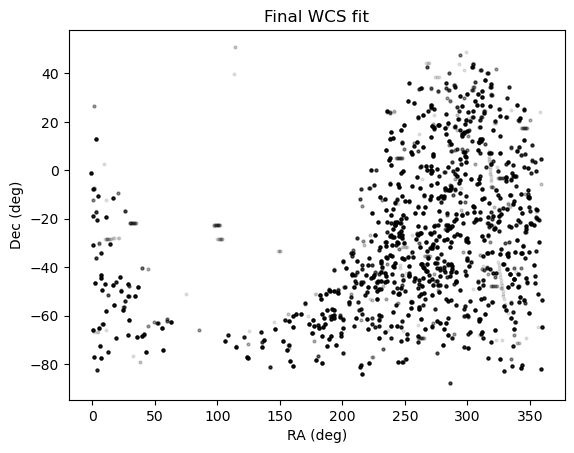

In [29]:
plt.plot(ra,dec, 'ko', alpha=0.1, markersize=2)
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')
plt.title('Final WCS fit')

Text(0.5, 1.0, 'Initial WCS guess')

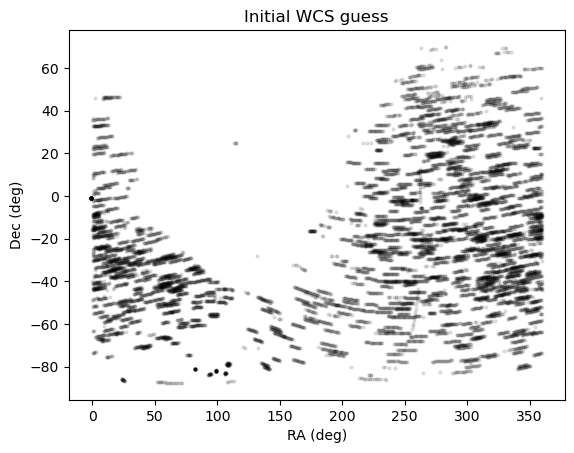

In [30]:
# What did the initial guess look like?
fitting_obj(x0)
ra,dec = fitting_obj._xy2radec(fitting_obj.w)
plt.plot(ra,dec, 'ko', alpha=0.1, markersize=2)
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')
plt.title('Initial WCS guess')

Text(0.5, 1.0, 'Initial WCS guess')

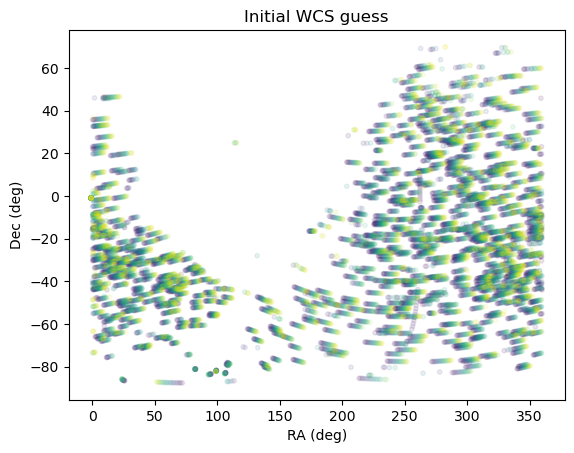

In [31]:
plt.scatter(ra,dec, c=mjds, alpha=0.1, s=10)
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')
plt.title('Initial WCS guess')

In [32]:
fitting_obj(best_fit.x)
fitting_obj.w

WCS Keywords

Number of WCS axes: 2
CTYPE : 'ALON-ZEA'  'ALAT-ZEA'  
CRVAL : 180.0  90.0  
CRPIX : 2249.9999752095105  1500.0002875214589  
PC1_1 PC1_2  : 0.18073991592633845  0.9894460162609574  
PC2_1 PC2_2  : -1.003214321397465  0.18699834958421405  
CDELT : -0.049232665804725524  0.048118344099894184  
NAXIS : 0  0

In [33]:
# This looks bad, because the CRPIX values didn't change, but looks like it's actually degenerate with 
# the PC martix, so it all works out!

# There are other projections one could try (ARC and ZPN being the obvious other options). Also need to 
# figure out how one could add some SIP fitting on here as well.